In [20]:
import pandas as pd
import os

In [21]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("aljarah/xAPI-Edu-Data")

# print("Path to dataset files:", path)

In [22]:
df_path = r"C:\Users\Fhuan\.cache\kagglehub\datasets\aljarah\xAPI-Edu-Data\versions\6\xAPI-Edu-Data.csv"
df = pd.read_csv(df_path)
display(df)

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,F,Jordan,Jordan,MiddleSchool,G-08,A,Chemistry,S,Father,5,4,5,8,No,Bad,Above-7,L
476,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,F,Father,50,77,14,28,No,Bad,Under-7,M
477,F,Jordan,Jordan,MiddleSchool,G-08,A,Geology,S,Father,55,74,25,29,No,Bad,Under-7,M
478,F,Jordan,Jordan,MiddleSchool,G-08,A,History,F,Father,30,17,14,57,No,Bad,Above-7,L


In [23]:
df.columns

Index(['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID',
       'SectionID', 'Topic', 'Semester', 'Relation', 'raisedhands',
       'VisITedResources', 'AnnouncementsView', 'Discussion',
       'ParentAnsweringSurvey', 'ParentschoolSatisfaction',
       'StudentAbsenceDays', 'Class'],
      dtype='object')

In [24]:
# Reemplazar valores vacíos por NaN
df.replace(["?", "NA", "None", ""], pd.NA, inplace=True)


=== REPORT ===
              precision    recall  f1-score   support

           h       0.76      0.72      0.74        36
           l       0.90      0.90      0.90        31
           m       0.76      0.79      0.78        53

    accuracy                           0.80       120
   macro avg       0.81      0.81      0.81       120
weighted avg       0.80      0.80      0.80       120



C:\Users\Fhuan\AppData\Local\Temp\ipykernel_19048\3148666686.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


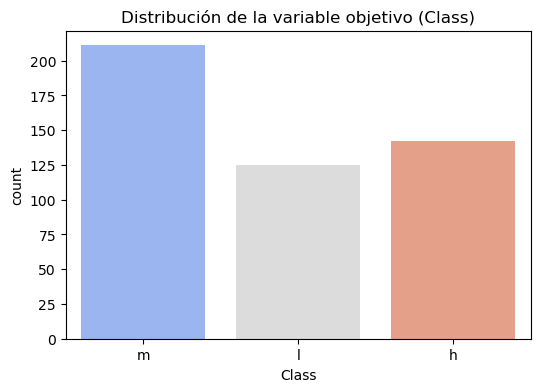

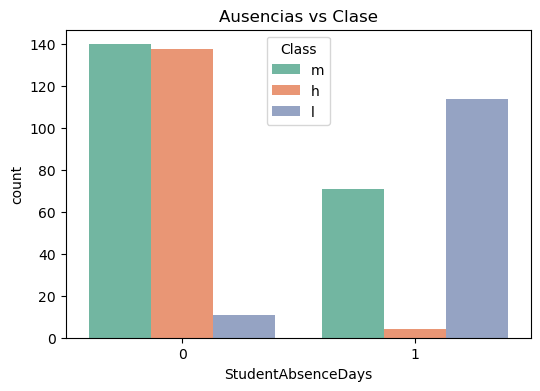

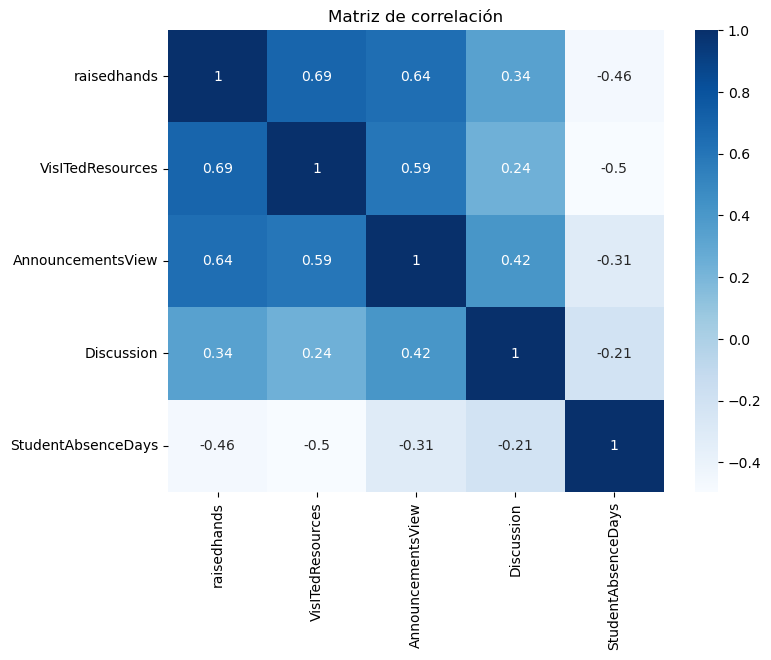

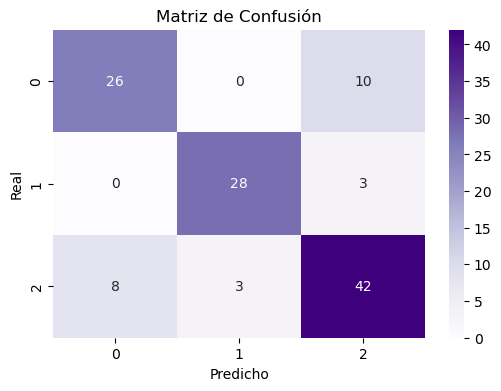

C:\Users\Fhuan\AppData\Local\Temp\ipykernel_19048\3148666686.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")


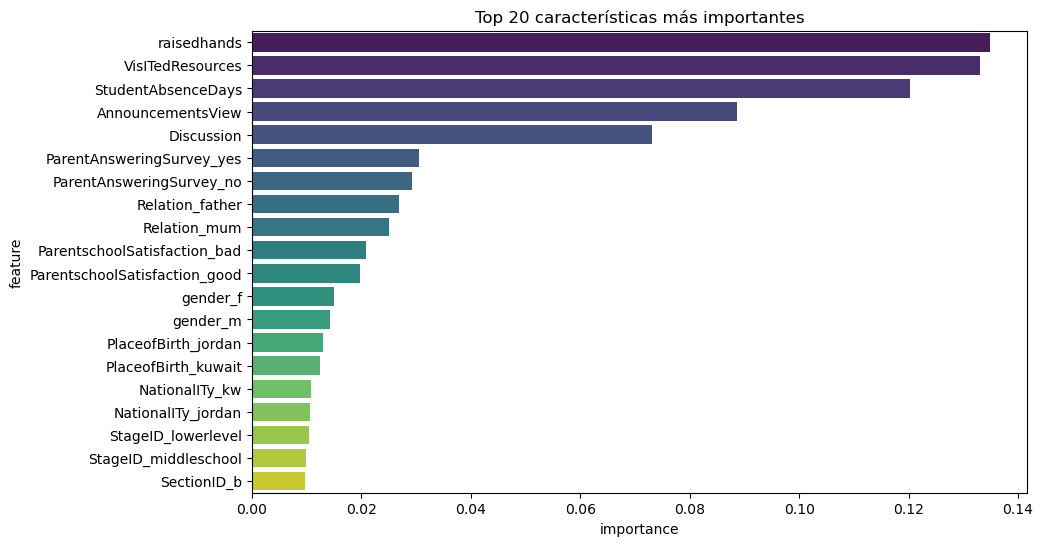

In [29]:
# ============================================================
#    LIMPIEZA DE DATOS + PREDICCIÓN + GRÁFICOS
#    Python 3.13.7
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# 1. ---------- LIMPIEZA DE DATOS ----------
# ============================================================

# ---------------------------------------
# 1.1 Eliminar duplicados
# ---------------------------------------
df = df.drop_duplicates()

# ---------------------------------------
# 1.2 Normalizar texto (evitar "male", "Male", "M")
# ---------------------------------------
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# ---------------------------------------
# 1.3 Reemplazar valores nulos
#     • Categóricas → "unknown"
#     • Numéricas → mediana
# ---------------------------------------
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("unknown")
    else:
        df[col] = df[col].fillna(df[col].median())

# --------------------------------------------------------------
# 1.4 Convertir "StudentAbsenceDays" si viene como "under-7"/"above-7"
# --------------------------------------------------------------
if df["StudentAbsenceDays"].dtype == "object":
    df["StudentAbsenceDays"] = df["StudentAbsenceDays"].replace({
        "under-7": 0,
        "above-7": 1
    })

# --------------------------------------------------------------
# 1.5 Manejo de outliers en columnas numéricas (winsorization)
#     Se cortan valores extremos por percentil 1% y 99%
# --------------------------------------------------------------
numeric_cols = df.select_dtypes(include=["int", "float"]).columns

for col in numeric_cols:
    p1 = df[col].quantile(0.01)
    p99 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], p1, p99)

# ============================================================
# 2. ---------- MODELO ----------
# ============================================================

X = df.drop(columns=["Class"])
y = df["Class"]

categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int", "float"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

# División de datos (después de limpieza)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n=== REPORT ===")
print(classification_report(y_test, y_pred))

# ============================================================
# 3. ---------- GRÁFICOS ----------
# ============================================================

# ---------------------------------
# Distribución de clases
# ---------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Distribución de la variable objetivo (Class)")
plt.show()

# ---------------------------------
# Ausencias vs clase
# ---------------------------------
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="StudentAbsenceDays", hue="Class", palette="Set2")
plt.title("Ausencias vs Clase")
plt.show()

# ---------------------------------
# Matriz de correlación
# ---------------------------------
plt.figure(figsize=(8,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Matriz de correlación")
plt.show()

# ---------------------------------
# Matriz de confusión
# ---------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# ---------------------------------
# Importancia de variables
# ---------------------------------
encoder = pipeline.named_steps["preprocess"].named_transformers_["cat"]
encoded_cols = encoder.get_feature_names_out(categorical_cols)

feature_names = list(encoded_cols) + list(numeric_cols)
importances = model.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=imp_df, x="importance", y="feature", palette="viridis")
plt.title("Top 20 características más importantes")
plt.show()

# ---------------------------------
# Curva ROC (si 'class' tiene 'dropout')
# ---------------------------------
if "dropout" in y.unique():
    pos_class = list(pipeline.classes_).index("dropout")
    y_prob = pipeline.predict_proba(X_test)[:, pos_class]

    y_test_bin = y_test.apply(lambda x: 1 if x == "dropout" else 0)

    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - Deserción (Dropout)")
    plt.legend()
    plt.show()
